In [1]:
#!pip install nltk
#!pip install --upgrade pip
#!pip install JPype1-1.2.0-cp38-cp38-win_amd64.whl
#!pip install konlpy
#!pip install wordcloud
#!pip install numpy

# 데이터 전처리 과정

In [838]:
from konlpy.tag import Kkma

## 데이터 분석

In [2035]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

* 데이터 크기, 수, 길이 확인

In [840]:
DATA_IN_PATH = './dataset.csv'
print('파일크기 : ' + str(round(os.path.getsize(DATA_IN_PATH) / 1000000, 2)) + 'MB')

파일크기 : 1.04MB


In [841]:
train_data = pd.read_csv(DATA_IN_PATH, header = 0)
train_data.head()

In [843]:
print('전체 데이터 수: {}'.format(len(train_data)))

전체 데이터 수: 10000


In [844]:
train_lenght = train_data['txt'].astype(str).apply(len)
train_lenght.head()

0     12
1     40
2    103
3     60
4     28
Name: txt, dtype: int64

### 데이터의 평균적인 길이를 추론

Text(0, 0.5, 'number')

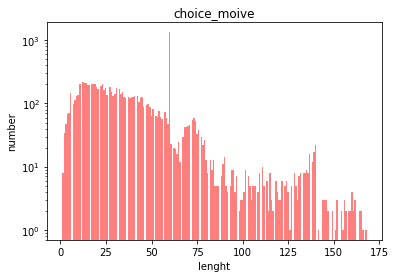

In [845]:
plt.hist(train_lenght, bins=200, alpha=0.5, color= 'r', label='word')
plt.yscale('log', nonpositive='clip')
plt.title('choice_moive')
plt.xlabel('lenght')
plt.ylabel('number')

* 그래프에서 50자 이내로 가장 많이 분포되어있고 이후로는 서서히 줄어드는 것으로 보아 짧은 문자을 구사하는 채팅에 성질을 보인다

In [846]:
print('리뷰 길이 최댓값: {}'. format(np.max(train_lenght)))
print('리뷰 길이 최솟값: {}'. format(np.min(train_lenght)))
print('리뷰 길이 평균값: {:.2f}'. format(np.mean(train_lenght)))
print('리뷰 길이 표준편차: {:.2f}'. format(np.std(train_lenght)))
print('리뷰 길이 중간값: {}'. format(np.median(train_lenght)))

리뷰 길이 최댓값: 168
리뷰 길이 최솟값: 1
리뷰 길이 평균값: 38.51
리뷰 길이 표준편차: 26.00
리뷰 길이 중간값: 33.0


* 평균에 경우 38이고 중간값과도 6정도에 차이를 보인다

{'whiskers': [<matplotlib.lines.Line2D at 0x1c9d35cdac0>,
 'caps': [<matplotlib.lines.Line2D at 0x1c9ca306190>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c9d3e6bc70>],
 'medians': [<matplotlib.lines.Line2D at 0x1c9c6b28310>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c9d3dd9880>],
 'means': [<matplotlib.lines.Line2D at 0x1c9d3dd9fd0>]}

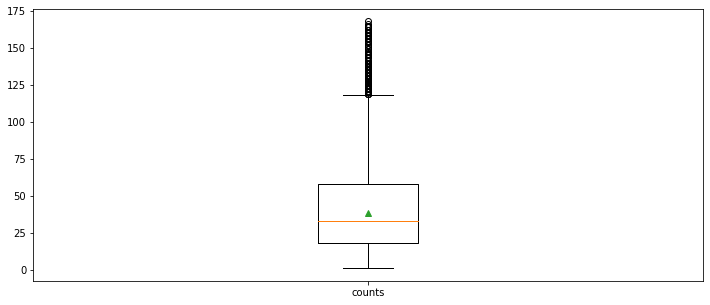

In [847]:
plt.figure(figsize=(12, 5))
plt.boxplot(train_lenght, labels=['counts'], showmeans=True)

### 어휘 빈도 확인
* 사전 제작시 빈도수가 높은 단어를 참고하여 전처리하기 위한 과정
* 불필요한 단어의 빈도수가 높은 경우 제거

In [848]:
train_re = [re for re in train_data['txt'] if type(re) is str]

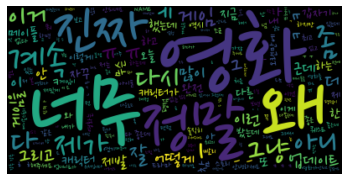

In [849]:
wordcloud = WordCloud(font_path = './NanumPen.ttf').generate(' '.join(train_re))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

* 데이터에서 많이 사용되는 단어 중에 "왜", "너무", "정말", "좀", "잘", "진짜" 같이 추임새가 상당히 많은 편이다 
  이러한 추임새를 데이터 전처리에서 불용어 사전에 추가하여 제거하는게 좋을 듯하다.

### 단어 빈도 확인
* 평균값과 중간값 차이가 크지 않아 모델에 적용할 길이 10정도 예상

In [850]:
train_word_counts = train_data['txt'].astype(str).apply(lambda x:len(x.split(' ')))

Text(0, 0.5, 'number of re')

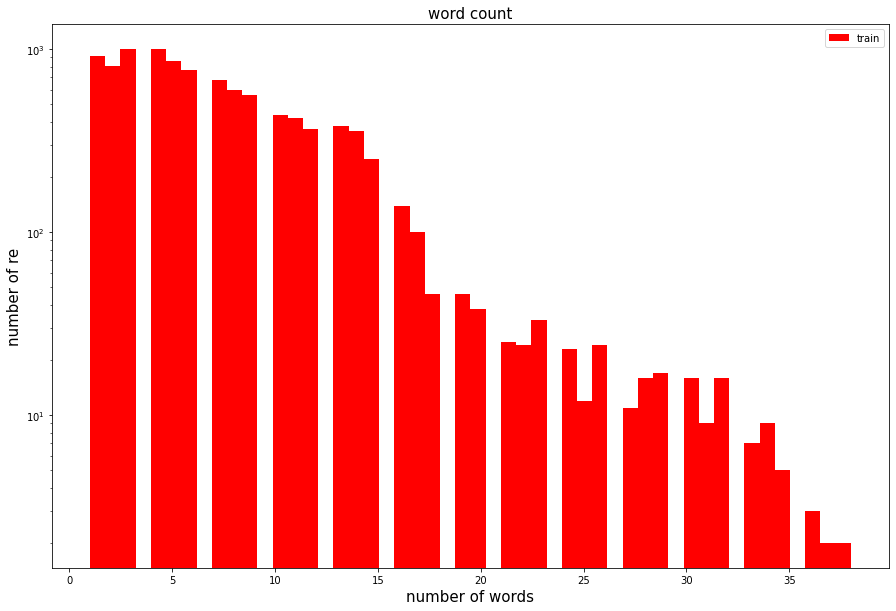

In [851]:
plt.figure(figsize=(15, 10))
plt.hist(train_word_counts, bins=50, facecolor='r', label='train')
plt.title('word count', fontsize=15)
plt.yscale('log', nonpositive='clip')
plt.legend()
plt.xlabel('number of words', fontsize=15)
plt.ylabel('number of re', fontsize=15)

In [852]:
print('단어 최댓값: {}'. format(np.max(train_word_counts)))
print('단어 최솟값: {}'. format(np.min(train_word_counts)))
print('단어 평균값: {:.2f}'. format(np.mean(train_word_counts)))
print('단어 표준편차: {:.2f}'. format(np.std(train_word_counts)))
print('단어 중간값: {}'. format(np.median(train_word_counts)))

단어 최댓값: 38
단어 최솟값: 1
단어 평균값: 7.31
단어 표준편차: 5.42
단어 중간값: 6.0


## 데이터 전처리

In [2034]:
import re
import json
from konlpy.tag import Okt
import tensorflow as tf
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer

### 정규표현식을 통해서 숫자, 영어, 한글을 제외하고 불필요한 것 모두 제거

In [854]:
 re_text = re.sub("[^1-9a-zA-Z가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", train_data['txt'][21])

### 형태소 분석시를 적용하여 형태소 단위 토크나이징
* 어간 추출을 사용해 어간이 추출된 단어로 나눔
* 어간 추출이 글의 잠재적의미 회손이 가장 덜하다고 판담함
* 서술어 , 명사, 또한 서술어를 일관성있게 만들어 판단이 쉬울거라 예상함

In [856]:
okt=Okt()
re_text1 = okt.nouns(re_text)
print(re_text1)

['오승아']


In [857]:
re_text2 = okt.morphs(re_text)
print(re_text2)

['오승아', '너무', '좋았다']


In [858]:
re_text2 = okt.morphs(re_text, stem=True)
print(re_text2)

['오승아', '너무', '좋다']


In [859]:
re_text3 = okt.phrases(re_text)
print(re_text3)

['오승아']


In [860]:
re_text4 = okt.pos(re_text, join=True)
print(re_text4)

['오승아/Noun', '너무/Adverb', '좋았다/Adjective']


#### 불용어 제거
* 불용어 목록을 txt 파일로 만든 후 해당 목록에 있는 불용어를 제거한다.

In [861]:
stop_word = pd.read_csv('./ko_stopword.txt',header = 0)
stop_word = np.array(stop_word['txt'].tolist())
stop_words = set(stop_word)

In [862]:
clean_text = [token for token in re_text2 if not token in stop_words]
print(clean_text)

['오승아', '좋다']


#### 전처리 과정 함수 제작
* 위 전처리과정을 담은 함수를 제작

In [863]:
 def preprocessing(text, okt, re_stopword = True):
        
        re_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", text) #한글외 삭제
         
        re_text2 = okt.morphs(re_text, stem=True) #어간추출
        
        if re_stopword:
            clean_text = [token for token in re_text2 if not token in stop_words] #불용어 처리
            
        clean_text = ' '.join(clean_text)

        return clean_text

### 전처리 과정 일괄 수행

In [2119]:
clean_train_word=[]

for re_text in train_data['txt']:

    if type(re_text) == str:
        clean_train_word.append(preprocessing(re_text, okt))
    else
        clean_train_word.append([])

In [2291]:
clean_train_df = pd.DataFrame({'txt': clean_train_word, 'sentiment': train_data['txt']}) 
clean_train_df.to_csv('./train_clean.csv', index=False ,encoding='utf-8-sig' )
#모델에 따라서 입력값 다를수 있어 저장

### 결측값 제거
* 빈문자열 nan으로 변환 후 제거

In [2293]:
clean_train_df.replace('', np.nan, inplace=True)

In [2294]:
clean_train_df.isnull().sum()

txt          93
sentiment     0
dtype: int64

In [2295]:
clean_train_df = clean_train_df.dropna()

In [2296]:
clean_train_df.isnull().sum()

txt          0
sentiment    0
dtype: int64

In [2297]:
len(clean_train_df)

9907

In [2298]:
clean_train_df.to_csv('./train_clean.csv', index=False ,encoding='utf-8-sig' )

### 문장당 단어 개수 확인
* 전처리 후에 문장당 단어 개수 모델에 적용할 길이 30정도 예상

In [866]:
train_word_counts = clean_train_df['txt'].astype(str).apply(lambda x:len(x.split(' ')))

In [867]:
print('단어 최댓값: {}'. format(np.max(train_word_counts)))
print('단어 최솟값: {}'. format(np.min(train_word_counts)))
print('단어 평균값: {:.2f}'. format(np.mean(train_word_counts)))
print('단어 표준편차: {:.2f}'. format(np.std(train_word_counts)))
print('단어 중간값: {}'. format(np.median(train_word_counts)))

단어 최댓값: 69
단어 최솟값: 1
단어 평균값: 11.08
단어 표준편차: 7.93
단어 중간값: 9.0


* 평균값과 중간값이 10 - 11 정도

Text(0, 0.5, 'number of re')

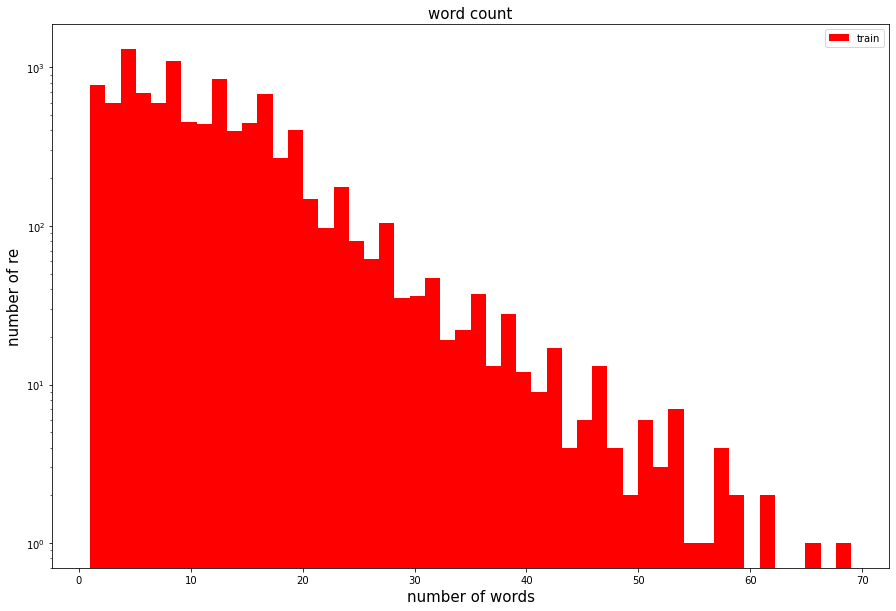

In [868]:
plt.figure(figsize=(15, 10))
plt.hist(train_word_counts, bins=50, facecolor='r', label='train')
plt.title('word count', fontsize=15)
plt.yscale('log', nonpositive='clip')
plt.legend()
plt.xlabel('number of words', fontsize=15)
plt.ylabel('number of re', fontsize=15)

* 그래프상 대부분 20개 이내의 단어를 가지고 있다.
* 많은 부분도 어느정도 비율을 차지하므로 이를 고려하여 25 - 30정도가 적당하다 판단

# 라벨링 확보 과정

## 라벨링을 위한 모델링 전체 과정 설명 

## 1. 영화리뷰데이터전처리

### 영화리뷰 데이터 분석

In [869]:
moive_review_word = pd.read_csv('./moive_review_nlp.txt', header = 0, sep='\t', low_memory=False)

### 어휘 빈도 확인
* 사전 제작시 빈도수가 높은 단어를 참고하여 전처리하기 위한 과정
* 불필요한 단어의 빈도수가 높은 경우 제거

In [870]:
train_re = [re for re in moive_review_word['document'] if type(re) is str]

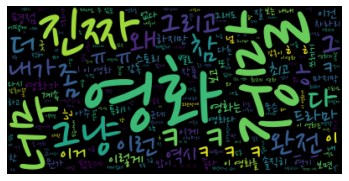

In [58]:
wordcloud = WordCloud(font_path = './NanumPen.ttf').generate(' '.join(train_re))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

* 정말 , 너무 , 진짜, ㅋㅋㅋ ,그냥 등 불용어처리하기

### 추가 영화 리뷰 데이터 전처리

In [59]:
def label_preprocessing(text, okt, re_stopword = True):
        
        re_text = re.sub("[^가-힣\\s]", "", text)
        
        re_text2 = okt.morphs(re_text, stem=True)
        
        if re_stopword:
            clean_text = [token for token in re_text2 if not token in stop_words]

        return clean_text

* 확실한 단어만 추출하기 위해서 전처리시 한글만 허용

In [60]:
moive_word=[]

for re_text in moive_review_word['document']:

    if type(re_text)==str:
        moive_word.append(label_preprocessing(re_text, okt))
    else:
        moive_word.append([])


In [88]:
#np.save(open('./moive_input2.npy', 'wb'), moive_word)
#전처리한 문장 파일로 저장

In [89]:
train_input = np.load(open('./moive_input2.npy', 'rb'), allow_pickle=True)

In [63]:
moive_input = []

for m in train_input:
    for w in m:
         moive_input.append(w)

* 1차원으로 변환

### 영화 리뷰 데이터 단어 추출 사전 제작
* 단어 빈도 수가 높은 순으로 추출

In [1724]:
from collections import Counter

count = Counter(moive_input)

morphs_list = count.most_common(1000) # 단어 빈도수 높은 순 추출

In [1725]:
moive_word_input = []
for w in morphs_list:
    moive_word_input.append(w[0])

In [1726]:
moive_word_input = np.array(moive_word_input)
moive_word_input = set(moive_word_input)

## 2. 초기 일부 데이터 라벨링을 위한 수작업
* 일정 데이터에 대한 라벨링을 수작업으로 진행한 후 이후 자동시스템으로 라벨링
* 모든 데이터를 확인하며 100개 라벨링 어려움. 
* 네이버 영화리뷰 데이터와 미분류데이터의 단어가 있을 시 출력해서 라벨링

### 수동라벨링위한 추출
* 영화리뷰데이터로 만든 사전을 기준으로 문장을 추출
* 추출된 문장 확인 후 라벨링 진행

* 영화관련 문장 (1) : 100개
* 무관한 문장(0) : 100개

In [1747]:
right_text = []
wrong_text = []

c = 0
for text in clean_train_word: 
  
    c = 0
    
    words = text.split(' ')
    
    for token in  words:
        if token in moive_word_input: #사전안에 단어가 있는 경우 영화관련 문장으로 예측
            c = c + 1
            
    if c == 0:
        wrong_text.append(text)        # 영화관련 문장리스트 (9단어 이상 있어야함)
            
    elif c > 20:
        right_text.append(text)        # 아닌경우리스트

* 세개의 파일(증식할 데이터 넣는 곳, 라벨링된 원본 + 전처리된 데이터, 최종라벨링 파일)
* 1, 0 (영화관련된 문장, 아닌 문장) 각각 파일 
* 원본데이터와 전처리이 데이터가 매핑되어있는 csv 파일(테스트 데이터로 활용예정)에서 라벨링된 데이터 제거
#### 라벨링된 데이터 제거하고 테스트할 데이터 만들기(직접해야함)


In [1748]:
right_text = pd.DataFrame({'txt': right_text }) 
right_text.to_csv('./right_text.csv', index=False ,encoding='utf-8-sig' ) #증식데이터와 원본데이터 다 넣음
right_text.to_csv('./right_text_re.csv', index=False ,encoding='utf-8-sig' ) #데이터 증식될 문장만 넣는곳
right_text.to_csv('./right_text_result.csv', index=False ,encoding='utf-8-sig' )#최종라벨링이 된 문장

In [1750]:
wrong_text = pd.DataFrame({'txt': wrong_text}) 
wrong_text.to_csv('./wrong_text.csv', index=False ,encoding='utf-8-sig' ) #증식데이터와 원본데이터 다 넣음
wrong_text.to_csv('./wrong_text_re.csv', index=False ,encoding='utf-8-sig' )#데이터 증식될 문장만 넣는곳
wrong_text.to_csv('./wrong_text_result.csv', index=False ,encoding='utf-8-sig' ) #최종라벨링이 된 문장

#### 라벨링 된 문장 원본데이터에서 제거

In [2129]:
right_text = pd.read_csv('./right_text.csv', header = 0)
wrong_text = pd.read_csv('./wrong_text.csv', header = 0)
clean_data = pd.read_csv('./train_clean.csv', header = 0)

In [2130]:
right_text = right_text['txt'].tolist()
wrong_text = wrong_text['txt'].tolist()

In [2131]:
clean_train = []
data_list = []
check = []
for text, data in zip(clean_data['txt'], clean_data['sentiment']):
    if text in right_text:  
        pass
    elif text in wrong_text:
        check.append(text)
    else:
        clean_train.append(text) #라벨링되지않은 데이터만 저장
        data_list.append(data) 

In [2286]:
clean_train_df = pd.DataFrame({'txt': clean_train, 'sentiment': data_list}) 
clean_train_df.to_csv('./train_clean.csv', index=False ,encoding='utf-8-sig' ) #테스트 데이터로 활용

In [2287]:
len(clean_train_df)

9701

### (txt 파일보고 직접 수행)
* 각각 txt 자료에서 실제 1, 0 에 해당하는 문장 100개 제외하고 모두 삭제

* 데이터 증식한 데이터만 사용할 파일 제작 내용 적용(훈련때마다 증식되는 데이터만)

### 데이터 증식

안전하게 데이터 증강을 하기위해 RD, RS만을 사용.
RI, SR은 의미 변형을 일으킬 가능성 있음

#### RS : 단어 간 바꾸기(교환)

In [2032]:
import pickle
import random

In [2036]:
def random_swap(words, n):
    new_words = words.copy()
    
    for _ in range(n):
        new_words = swap_word(new_words) 

    return new_words  

def swap_word(new_words):
    random_idx_1 = random.randint(0, len(new_words)-1)  #랜덤으로 교환할 인덱스 결정
    random_idx_2 = random_idx_1
    counter = 0

    while random_idx_2 == random_idx_1:
        random_idx_2 = random.randint(0, len(new_words)-1)
        counter += 1 
        if counter > 3: # 랜덤을 돌려도 계속 인덱스가 겹칠경우(3번) 원래값 리턴
                return new_words
    
    #인덱스에 단어 서로 맞교환 후에 리턴
    new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1]
    return new_words

#### RD : 랜덤선택하여 단어 삭제

In [2037]:
def random_deletion(words, p):
    if len(words) == 1:
        return words

    new_words = []
    for word in words:
        r = random.uniform(0, 1)  #랜덤으로 확률 지정 P 확률이상일 시 단어추가 아니면 삭제
        if r > p:                
            new_words.append(word)

    if len(new_words) == 0:
        rand_int = random.randint(0, len(words)-1) #모두 제거된 경우 랜덤 인덱스 후 단어하나 선택하여 출력
        return [words[rand_int]]

    return new_words

* 증식된 데이터 각 파일에 저장

In [2012]:
right_text_re = pd.read_csv('./right_text_re.csv', header = 0)
wrong_text_re = pd.read_csv('./wrong_text_re.csv', header = 0)
right_text_re = right_text_re['txt'].tolist()
wrong_text_re = wrong_text_re['txt'].tolist()

In [2013]:
list_file_re = []
for line in right_text_re :
    list_file_re.append(line.split(' '))

list_file_re2 = []
for line in wrong_text_re:
    list_file_re2.append(line.split(' '))

In [2153]:
sw_de_data = []

for words in list_file_re: 
    num =  len(words)#단어 길이에 따라 확률값과 교환 획수 결정
    if num > 1:
        n_rs = np.max([1, int(0.1*num)]) #교환횟수
        p_rd = random.uniform(0, 1) #삭제확률값
        a_words = random_swap(words, n_rs) 
        b_words = random_deletion(words, p_rd)
        Stra = " ".join(a_words)  
        Strb = " ".join(b_words) 
        sw_de_data.append(Stra)
        sw_de_data.append(Strb)

In [2047]:
sw_de_data2 = []

for words in list_file_re2: 
    num =  len(words) #단어 길이에 따라 확률값과 교환 획수 결정
    if num > 1:
        n_rs = np.max([1, int(0.1*num)]) #교환횟수
        p_rd = random.uniform(0, 1) #삭제확률값
        a_words = random_swap(words, n_rs) 
        b_words = random_deletion(words, p_rd)
        Stra = " ".join(a_words)  
        Strb = " ".join(b_words) 
        sw_de_data2.append(Stra)
        sw_de_data2.append(Strb)

In [2049]:
sw_de_df = pd.DataFrame({'txt': sw_de_data }) 
sw_de_df.to_csv('./right_text.csv', mode='a',header=False, index=False ,encoding='utf-8-sig' ) #테스트 데이터로 활용
sw_de_df2 = pd.DataFrame({'txt': sw_de_data2 }) 
sw_de_df2.to_csv('./wrong_text.csv', mode='a',header=False, index=False ,encoding='utf-8-sig' ) #테스트 데이터로 활용

* 증식 데이터와 원본 데이터 병합
* 라벨링이 된 원본데이터만 허용 함.(원본은 같은 파일에 저장되어있음)

### 라벨링 확보된 일부 데이터 훈련모델 적용을 위한 전처리

In [2050]:
right_text = pd.read_csv('./right_text.csv', header = 0)
wrong_text = pd.read_csv('./wrong_text.csv', header = 0)
right_text = right_text['txt'].tolist()
wrong_text = wrong_text['txt'].tolist()
array1 = np.array(right_text)   
array3 = np.array(wrong_text)   
total_train = np.concatenate([array1,array3], axis=0) #병합

In [2051]:
really_data = pd.read_csv('./train_clean.csv', header = 0)
really_data = really_data['txt'].tolist()
really_data = np.array(really_data)

In [2052]:
array1_label = np.ones(len(right_text))
array3_label = np.zeros(len(wrong_text))
total_label = np.concatenate([array1_label,array3_label], axis=0) #병합

In [2053]:
tmp = [[x,y] for x, y in zip(total_train, total_label)]

In [2054]:
random.shuffle(tmp) #데이터셋이 골고루 분포하도록 섞음

In [2055]:
total_train = [n[0] for n in tmp]
total_label = [n[1] for n in tmp]

* 변환사전
* 인덱스변환
* 사이즈 패딩
* 벡터화

In [2056]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_word) #전체데이터를 전처리했던 걸로 변환사전만들기
train_sequences = tokenizer.texts_to_sequences(total_train) #데이터증식한 라벨링된 데이터
test_sequences = tokenizer.texts_to_sequences(really_data) #라벨링데이터를 제외한 데이터
# 인덱스의 벡터로 구성

word_vocab = tokenizer.word_index 

MAX_SEQUENCE_LENGH = 35 # 문장 최대 길이 

train_inputs = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGH, padding='post')
test_inputs = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGH, padding='post')
train_labels = np.array(total_label)
#패딩 처리

In [2057]:
TRAIN_INPUT_DATA = './train_input.npy'
TEST_INPUT_DATA = './test_input.npy'
TRAIN_IABEL = './train_label.npy'
DATA_CONFIGS = './data_configs.json'

data_configs = {}

data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab)+1 #vocab size 추가

#전처리된 학습 데이터를 넘파이 형태로 저장 
np.save(open(TRAIN_INPUT_DATA, 'wb'), train_inputs)
np.save(open(TEST_INPUT_DATA, 'wb'), test_inputs)
np.save(open(TRAIN_IABEL, 'wb'), train_labels)
#평가데이터 넘파이 형태로 저장

#데이터 사전을 json 형태로 저장
json.dump(data_configs, open(DATA_CONFIGS, 'w'), ensure_ascii=False)

## 3.자동 데이터라벨링을 위한 모델링과 작업과정 구축
* 일부 라벨링된 데이터로 모델 훈련(검증셋, 훈련셋 분배)
* 훈련된 모델로 test 예측값 출력
* 0.9 이상/ 0.2 미만 의 예측값의 데이터 라벨링(이미 라벨링된 문장은 제외하기)
* 데이터 증식 
* 라벨링된 데이터간 병합 후에 전처리 
* 작업할 것이 100개 이하일 경우 (확률상) 중지 
* 애매한 확률들은 직접 확인 분류하기

In [2058]:
import json
import os
from konlpy.tag import Okt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2059]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [2060]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

#### 2) RNN

In [2061]:
train_input = np.load(open('./train_input.npy', 'rb'))
train_input = pad_sequences(train_input, maxlen=train_input.shape[1])
train_label = np.load(open('./train_label.npy', 'rb'))
test_input = np.load(open('./test_input.npy', 'rb'))
test_input = pad_sequences(test_input, maxlen=test_input.shape[1])
prepro_configs = json.load(open('./data_configs.json', 'r'))

In [2355]:
model_name = 'rnn_classifier_en'
BATCH_SIZE = 64
NUM_EPOCHS = 100
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]
global i
i = 0
kargs = {'model_name': model_name,
        'vocab_size': prepro_configs['vocab_size'],
        'embedding_dimension': 100,
        'dropout_rate': 0.2,
        'lstm_dimension': 150,
        'dense_dimension': 150,
        'output_dimension':1}

* 적은 데이터인 만큼 과적합 방지를 위해서 층을 단순화

In [2356]:
class RNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(RNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                     output_dim=kargs['embedding_dimension']) #데이터 사전 수와, 임베딩 차원 수 입력
        self.lstm_1_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'], return_sequences=True)
        # lstm를 통해 각 문장의 의미벡터 출력 
        #마지막 시퉌스의 은닉 상태 벡터를 얻기 위해서 첫레이어에서 다음 레이어에 입력할 시퀀스 벡터 구성(return_sequences=True)
        self.lstm_2_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'])
        #마지막 스템의 은닉상태 벡터 출력
        self.dropout = layers.Dropout(kargs['dropout_rate']) #과적합 방지 레리어
        self.fc1 = layers.Dense(units=kargs['dense_dimension'],
                           activation=tf.keras.activations.tanh)  
        #피드 포워드 네트워크(벡터 차원수, 활성화함수 지정)
        self.fc2 = layers.Dense(units=kargs['output_dimension'], 
                           activation=tf.keras.activations.sigmoid) 
        #회귀하게 만들기 위해 
        # 예측값 0 - 1 확률로 출력(sigmoid 활성화함수)
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.lstm_1_layer(x)
        x = self.lstm_2_layer(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [2357]:
model = RNNClassifier(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [2358]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=1)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)
global checkpoint_path

checkpoint_path =  './'+ model_name + '/' + str(i) + 'weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

./rnn_classifier_en -- Folder already exists 



In [1992]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/100
81/81 [==============================] - ETA: 0s - loss: 0.3455 - accuracy: 0.9481
Epoch 00001: val_accuracy improved from -inf to 0.96181, saving model to ./rnn_classifier_en\0weights.h5
81/81 [==============================] - 10s 127ms/step - loss: 0.3455 - accuracy: 0.9481 - val_loss: 0.1801 - val_accuracy: 0.9618
Epoch 2/100
81/81 [==============================] - ETA: 0s - loss: 0.1788 - accuracy: 0.9600
Epoch 00002: val_accuracy did not improve from 0.96181
81/81 [==============================] - 9s 107ms/step - loss: 0.1788 - accuracy: 0.9600 - val_loss: 0.1652 - val_accuracy: 0.9618


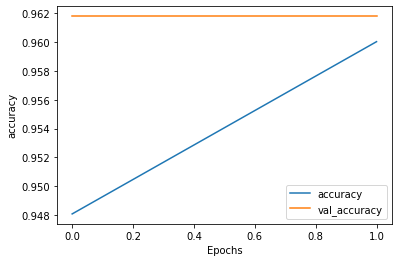

In [1993]:
plot_graphs(history, 'accuracy')

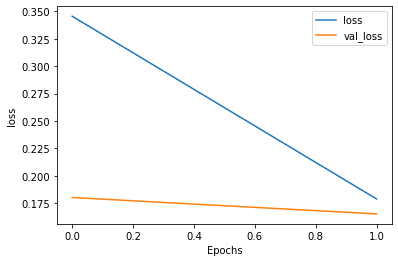

In [1994]:
plot_graphs(history, 'loss')

In [1995]:
really_data = pd.read_csv('./train_clean.csv', header = 0)
really_data.isnull().sum()

txt          0
sentiment    0
dtype: int64

In [1996]:
DATA_OUT_PATH = './data_out_result_rnn.csv'
SAVE_FILE_NM = './'+ model_name + '/' + str(i) + 'weights.h5'
global model_name
model.load_weights(SAVE_FILE_NM)

predictions = model.predict(test_input, batch_size=BATCH_SIZE)
predictions = predictions.squeeze(-1)

output =  pd.DataFrame(data={"sentiment":list(predictions)})
output.to_csv(DATA_OUT_PATH , index=False, quoting=3)

In [1997]:
global min_p 
global max_p

In [2026]:
mean = predictions.mean()
min_p = predictions.min() + 0.01
max_p = predictions.max() - 0.01

### 라벨링 가능 데이터 추출
* 예측값 확률
* 0.2 이하 / 0.8 이상인 데이터 추출

In [1999]:
predictions_out = pd.read_csv('./data_out_result_rnn.csv', 'r', header = 0)
really_data = pd.read_csv('./train_clean.csv', header = 0)
really_data = really_data['txt'].tolist()

In [2000]:
predictions_out = predictions_out['sentiment'].tolist()

In [2001]:
right_pred = []
wrong_pred = []

for num , text in zip(predictions_out,really_data) :
    
    if num <= min_p:
        wrong_pred.append(text)
          
    elif num >= max_p:
        right_pred.append(text)

In [1942]:
right_text = pd.DataFrame({'txt': right_pred}, columns=["txt"]) 
right_text.to_csv('./right_text.csv', mode='a', header=False, index=False ,encoding='utf-8-sig' )
right_text.to_csv('./right_text_re.csv', index=False ,encoding='utf-8-sig' )
right_text.to_csv('./right_text_result.csv', mode='a', index=False ,encoding='utf-8-sig' )#최종라벨링이 된 문장

In [1952]:
wrong_text = pd.DataFrame({'txt': wrong_pred}) 
wrong_text.to_csv('./wrong_text.csv', mode='a',header=False,  index=False ,encoding='utf-8-sig' ) #증식데이터와 원본데이터 다 넣음
wrong_text.to_csv('./wrong_text_re.csv', index=False ,encoding='utf-8-sig' ) #데이터 증식될 문장만 넣는곳
wrong_text.to_csv('./wrong_text_result.csv', mode='a',index=False ,encoding='utf-8-sig' )#최종라벨링이 된 문장

# 라벨링 모델 자동화 함수
* 데이터증식까지(증식함수제작) 수행 후 바로 여기서부터 수행하면 자동으로 라벨링
* 그 후 소스들은 테스트를 위한 코드

### 1. 데이터 로드

In [2260]:
model_name = 'rnn_classifier_en'
BATCH_SIZE = 32
NUM_EPOCHS = 100
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]
global i
i = 0
kargs = {'model_name': model_name,
        'vocab_size': prepro_configs['vocab_size'],
        'embedding_dimension': 100,
        'dropout_rate': 0.2,
        'lstm_dimension': 150,
        'dense_dimension': 150,
        'output_dimension':1}

In [ ]:
def data_pre():
    right_text = pd.read_csv('./right_text.csv', header = 0)
    wrong_text = pd.read_csv('./wrong_text.csv', header = 0)
    right_text = right_text['txt'].tolist()
    wrong_text = wrong_text['txt'].tolist()
    array1 = np.array(right_text)   
    array3 = np.array(wrong_text)   
    total_train = np.concatenate([array1,array3], axis=0) #병합

    really_data = pd.read_csv('./train_clean.csv', header = 0)
    really_data = really_data['txt'].tolist()
    really_data = np.array(really_data)

    array1_label = np.ones(len(right_text))
    array3_label = np.zeros(len(wrong_text))
    total_label = np.concatenate([array1_label,array3_label], axis=0) #병합

    tmp = [[x,y] for x, y in zip(total_train, total_label)]

    random.shuffle(tmp) #데이터셋이 골고루 분포하도록 섞음

    total_train = [n[0] for n in tmp]
    total_label = [n[1] for n in tmp]
    
    return total_train, total_label, really_data

### 2. 데이터전처리, 토크나이징
* 변환사전
* 인덱스변환
* 사이즈 패딩
* 벡터화

In [ ]:
def token_pre(total_train , total_label , really_data):
    train_sequences = tokenizer.texts_to_sequences(total_train) #데이터증식한 라벨링된 데이터
    test_sequences = tokenizer.texts_to_sequences(really_data) #라벨링데이터를 제외한 데이터
    # 인덱스의 벡터로 구성

    total_word_vocab = tokenizer.word_index 

    MAX_SEQUENCE_LENGH = 170 # 문장 최대 길이 
    
    # 패딩처리
    train_inputs = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGH, padding='post')
    test_inputs = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGH, padding='post')
    train_labels = np.array(total_label)
    TRAIN_INPUT_DATA = './train_input.npy'
    TEST_INPUT_DATA = './test_input.npy'
    TRAIN_IABEL = './train_label.npy'
    DATA_CONFIGS = './data_configs.json'

    data_configs = {}
    
    data_configs['vocab'] = word_vocab
    data_configs['vocab_size'] = len(word_vocab)+1 #vocab size 추가

    #전처리된 학습 데이터를 넘파이 형태로 저장 
    np.save(open(TRAIN_INPUT_DATA, 'wb'), train_inputs)
    np.save(open(TEST_INPUT_DATA, 'wb'), test_inputs)
    np.save(open(TRAIN_IABEL, 'wb'), train_labels)
    #평가데이터 넘파이 형태로 저장

    #데이터 사전을 json 형태로 저장
    json.dump(data_configs, open(DATA_CONFIGS, 'w'), ensure_ascii=False)
    
    return train_inputs, test_inputs, train_labels

### 3. 모델_생성_훈련_예측값추출
* 모델생성훈련
* 예측값 추출

In [ ]:
def model_build_predict(b):
    
    train_input = np.load(open('./train_input.npy', 'rb'))
    train_input = pad_sequences(train_input, maxlen=train_input.shape[1])
    train_label = np.load(open('./train_label.npy', 'rb'))
    test_input = np.load(open('./test_input.npy', 'rb'))
    test_input = pad_sequences(test_input, maxlen=test_input.shape[1])
    prepro_configs = json.load(open('./data_configs.json', 'r'))

    global BATCH_SIZE
    tonum = BATCH_SIZE 
    
    if b == 0:
        
        for x in range(1,10):
            
            num = len(train_input)/BATCH_SIZE  #배치사이즈를 조절에서 모델의 정확도 높이기 
                                               # 15 - 30 사이로 데이터가 훈련되도록 배치사이즈 조절

            if BATCH_SIZE < 513:
                break

            if num > 30:
                tonum = tonum*2

            elif num < 15:
                tonum = tonum/2

            else:
                break

    
    BATCH_SIZE = tonum
    
    
    print(BATCH_SIZE)
    
    earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=1)
    # min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
    # patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)
    global i
    
    i = i + 1
    
    global checkpoint_path
    
    checkpoint_path = './'+ model_name + '/' + str(i) + 'weights.h5'
   
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create path if exists
    if os.path.exists(checkpoint_dir):
        print("{} -- Folder already exists \n".format(checkpoint_dir))
    else:
        os.makedirs(checkpoint_dir, exist_ok=True)
        print("{} -- Folder create complete \n".format(checkpoint_dir)) 


    cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
    
    model = RNNClassifier(**kargs)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

    history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])
    
    DATA_OUT_PATH = './data_out_result_rnn.csv'
    SAVE_FILE_NM = checkpoint_path

    model.load_weights(SAVE_FILE_NM)

    predictions = model.predict(test_input, batch_size=BATCH_SIZE)
    predictions = predictions.squeeze(-1)

    output =  pd.DataFrame(data={"sentiment":list(predictions)})
    output.to_csv(DATA_OUT_PATH , index=False, quoting=3)
    
    global min_p  # 최저확률에서 +0.01 하여 높은 확률에 (=정확성이 높은) 문장만 추출
    global max_p  # 최고확률에서 -0.01 하여 낮은 확률에 (=정확성이 높은) 영화관련 문장이 아닌 추출
    
    mean = predictions.mean()
    min_p = predictions.min() + 0.01
    max_p = predictions.max() - 0.01
    
    print(predictions.min())

### 4. 라벨링진행
* 라벨링하기
* 예측값을 기준으로 정확한 문장 분류진행

In [ ]:
def label_data():
    predictions_out = pd.read_csv('./data_out_result_rnn.csv', 'r', header = 0)
    really_data = pd.read_csv('./train_clean.csv', header = 0)
    really_data = really_data['txt'].tolist()

    predictions_out = predictions_out['sentiment'].tolist()

    right_pred = []
    wrong_pred = []
    
    global min_p, max_p     
    
    for num , text in zip(predictions_out,really_data) :

        if num <= min_p: # 최저확률에서 +0.01 하여 높은 확률에 (=정확성이 높은) 문장만 추출
            wrong_pred.append((text, num))

        elif num >= max_p: # 최고확률에서 -0.01 하여 낮은 확률에 (=정확성이 높은) 영화관련 문장이 아닌 추출
            right_pred.append((text, num))
            
    
    r_p = []
    w_p = []  
    
    
    if len(right_pred) > 300:  #정확한 문장만을 추출하기 위해서 상위 200개에서 높은 확률의 문장 추출
        
        right_pred.sort(key=lambda x: x[1])
        
        for text, num in right_pred:
            r_p.append(text)
        
        right_text = pd.DataFrame({'txt': r_p[:200]})
    
    else:
        
        for text, num in right_pred:
            r_p.append(text)
            
        right_text = pd.DataFrame({'txt': r_p})
        
        
    
    if len(wrong_pred) > 300: #정확히 영화관련한 문장이 아닌것만 추출하기 위해서 상위 200개에서 낮은 확률의 문장 추출
        wrong_pred.sort(key=lambda x: -x[1])
        
        for text, num in wrong_pred:
            w_p.append(text)
        
        wrong_text = pd.DataFrame({'txt': w_p[:200]})
        
    else:
        
        for text, num in wrong_pred:
            w_p.append(text)
        
        wrong_text = pd.DataFrame({'txt': w_p})
        
            

   # right_text.dropna(how='all')
    right_text.to_csv('./right_text.csv', mode='a',header=False, index=False ,encoding='utf-8-sig' )
    right_text.to_csv('./right_text_re.csv', index=False ,encoding='utf-8-sig' )
    right_text.to_csv('./right_text_result.csv',mode='a',index=False ,encoding='utf-8-sig' )#최종라벨링이 된 문장
   # wrong_text.dropna(how='all')
    wrong_text.to_csv('./wrong_text.csv', mode='a',header=False, index=False ,encoding='utf-8-sig' ) #증식데이터와 원본데이터 다 넣음
    wrong_text.to_csv('./wrong_text_re.csv', index=False ,encoding='utf-8-sig' ) #데이터 증식될 문장만 넣는곳   
    wrong_text.to_csv('./wrong_text_result.csv', mode='a', index=False ,encoding='utf-8-sig' )#최종라벨링이 된 문장

### 5. 라벨링된 데이터는 원본에서 삭제
* 라벨링한 데이터를 원본데이터에서 삭제

In [ ]:
def no_label_data_delet():
    
    right_text = pd.read_csv('./right_text_re.csv', header = 0)
    wrong_text = pd.read_csv('./wrong_text_re.csv', header = 0)
    clean_data = pd.read_csv('./train_clean.csv', header = 0)

    right_text = right_text['txt'].tolist()
    wrong_text = wrong_text['txt'].tolist()

    clean_train = []
    data_list = []
    
    for text, data in zip(clean_data['txt'], clean_data['sentiment']):
        
        if text in right_text:  
            pass
        elif text in wrong_text:
            pass
        else:
            clean_train.append(text) #라벨링되지않은 데이터만 저장
            data_list.append(data) 
    
    clean_train_df = pd.DataFrame({'txt': clean_train, 'sentiment': data_list}) 
    clean_train_df.to_csv('./train_clean.csv', index=False ,encoding='utf-8-sig' ) #테스트 데이터로 활용

### 6. 데이터 증식
* 위에 정의해둔 RS, RD로 데이터를 증식시키기

In [ ]:
def label_data_plus():
    right_text_re = pd.read_csv('./right_text_re.csv', header = 0)
    wrong_text_re = pd.read_csv('./wrong_text_re.csv', header = 0)
    right_text_re = right_text_re['txt'].tolist()
    wrong_text_re = wrong_text_re['txt'].tolist()

    list_file_re = []
    for line in right_text_re :
        list_file_re.append(line.split(' '))

    list_file_re2 = []
    for line in wrong_text_re:
        list_file_re2.append(line.split(' '))

    sw_de_data = []

    for words in list_file_re: 
        num =  len(words) #단어 길이에 따라 확률값과 교환 획수 결정
        if num > 1:
            n_rs = np.max([1, int(0.1*num)]) #교환횟수
            p_rd = random.uniform(0, 1) #삭제확률값
            a_words = random_swap(words, n_rs) 
            b_words = random_deletion(words, p_rd)
            Stra = " ".join(a_words)  
            Strb = " ".join(b_words) 
            sw_de_data.append(Stra)
            sw_de_data.append(Strb)

    sw_de_data2 = []

    for words in list_file_re2: 
        num =  len(words) #단어 길이에 따라 확률값과 교환 획수 결정
        if num > 1:
            n_rs = np.max([1, int(0.1*num)]) #교환횟수
            p_rd = random.uniform(0, 1) #삭제확률값
            a_words = random_swap(words, n_rs) 
            b_words = random_deletion(words, p_rd)
            Stra = " ".join(a_words)  
            Strb = " ".join(b_words) 
            sw_de_data2.append(Stra)
            sw_de_data2.append(Strb)

    sw_de_df = pd.DataFrame({'txt': sw_de_data }) 
    sw_de_df.to_csv('./right_text.csv', mode='a',header=False, index=False ,encoding='utf-8-sig' ) #테스트 데이터로 활용
    sw_de_df2 = pd.DataFrame({'txt': sw_de_data2 }) 
    sw_de_df2.to_csv('./wrong_text.csv', mode='a',header=False, index=False ,encoding='utf-8-sig' ) #테스트 데이터로 활용

## 제작된 자동 함수를 적용해 반복문 수행
* 완료 시 라벨링 완료
* 남은 데이터는 수동으로 처리

In [2306]:
while 1:
    x,y,z = data_pre() #데이터 로드
    t,s,y = token_pre(x,y,z) #토크나이저
    
    if len(s) < 50: #분리한 원본데이터셋이 50개 이하면 중지하고 나머지는 직접 라벨링
        break
    
    model_build_predict(0)
    
    while 1:
        
        if (max_p - min_p) < 2: # 모델성능 높이기 위해서 예측값의 최고확률과 최저확률이 1이상 차이가 없다면 모호성 있다고 판단
                                # 배치사이즈를 조절한다
            if BATCH_SIZE > 32:
                BATCH_SIZE = BATCH_SIZE/2
                model_build_predict(1)
                
            else:
                break
        else:
            break
            
    label_data() #예측값을 기준으로 1, 0 분류하기
    no_label_data_delet() #이미 분류된 데이터는 원본 데이터에서 삭제
    label_data_plus()  # 데이터 증식시키기

./rnn_classifier_en -- Folder already exists 

32
./rnn_classifier_en -- Folder already exists 

Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 0.6844 - accuracy: 0.7053
Epoch 00001: val_accuracy improved from -inf to 0.81132, saving model to ./rnn_classifier_en\2weights.h5
15/15 [==============================] - 1s 100ms/step - loss: 0.6844 - accuracy: 0.7053 - val_loss: 0.6699 - val_accuracy: 0.8113
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 0.6456 - accuracy: 0.7874
Epoch 00002: val_accuracy did not improve from 0.81132
15/15 [==============================] - 1s 63ms/step - loss: 0.6456 - accuracy: 0.7874 - val_loss: 0.6014 - val_accuracy: 0.8113
0.4700451
./rnn_classifier_en -- Folder already exists 

32
./rnn_classifier_en -- Folder already exists 

Epoch 1/100
47/47 [==============================] - ETA: 0s - loss: 0.6384 - accuracy: 0.7355
Epoch 00001: val_accuracy improved from -inf to 0.89091, saving model to ./rnn_classifier_

Epoch 7/100
131/131 [==============================] - ETA: 0s - loss: 0.0442 - accuracy: 0.9854
Epoch 00007: val_accuracy did not improve from 0.97854
131/131 [==============================] - 8s 64ms/step - loss: 0.0442 - accuracy: 0.9854 - val_loss: 0.1180 - val_accuracy: 0.9635
0.000118712385
./rnn_classifier_en -- Folder already exists 

32
./rnn_classifier_en -- Folder already exists 

Epoch 1/100
165/165 [==============================] - ETA: 0s - loss: 0.5988 - accuracy: 0.6644
Epoch 00001: val_accuracy improved from -inf to 0.77436, saving model to ./rnn_classifier_en\12weights.h5
165/165 [==============================] - 12s 73ms/step - loss: 0.5988 - accuracy: 0.6644 - val_loss: 0.4922 - val_accuracy: 0.7744
Epoch 2/100
165/165 [==============================] - ETA: 0s - loss: 0.3174 - accuracy: 0.8655
Epoch 00002: val_accuracy improved from 0.77436 to 0.90256, saving model to ./rnn_classifier_en\12weights.h5
165/165 [==============================] - 11s 69ms/step - los

Epoch 2/100
496/497 [============================>.] - ETA: 0s - loss: 0.1621 - accuracy: 0.9354
Epoch 00002: val_accuracy improved from 0.90873 to 0.94898, saving model to ./rnn_classifier_en\32weights.h5
497/497 [==============================] - 33s 66ms/step - loss: 0.1621 - accuracy: 0.9354 - val_loss: 0.1475 - val_accuracy: 0.9490
Epoch 3/100
496/497 [============================>.] - ETA: 0s - loss: 0.1017 - accuracy: 0.9598
Epoch 00003: val_accuracy did not improve from 0.94898
497/497 [==============================] - 32s 65ms/step - loss: 0.1017 - accuracy: 0.9598 - val_loss: 0.1311 - val_accuracy: 0.9484
0.000102732796
./rnn_classifier_en -- Folder already exists 

32
./rnn_classifier_en -- Folder already exists 

Epoch 1/100
515/515 [==============================] - ETA: 0s - loss: 0.4637 - accuracy: 0.7489
Epoch 00001: val_accuracy improved from -inf to 0.92022, saving model to ./rnn_classifier_en\34weights.h5
515/515 [==============================] - 34s 66ms/step - lo

0.00014454126
./rnn_classifier_en -- Folder already exists 

32
./rnn_classifier_en -- Folder already exists 

Epoch 1/100
610/610 [==============================] - ETA: 0s - loss: 0.4411 - accuracy: 0.7675
Epoch 00001: val_accuracy improved from -inf to 0.92577, saving model to ./rnn_classifier_en\44weights.h5
610/610 [==============================] - 38s 63ms/step - loss: 0.4411 - accuracy: 0.7675 - val_loss: 0.1928 - val_accuracy: 0.9258
Epoch 2/100
610/610 [==============================] - ETA: 0s - loss: 0.1413 - accuracy: 0.9446
Epoch 00002: val_accuracy improved from 0.92577 to 0.94744, saving model to ./rnn_classifier_en\44weights.h5
610/610 [==============================] - 38s 62ms/step - loss: 0.1413 - accuracy: 0.9446 - val_loss: 0.1339 - val_accuracy: 0.9474
Epoch 3/100
610/610 [==============================] - ETA: 0s - loss: 0.0917 - accuracy: 0.9650 ETA: 
Epoch 00003: val_accuracy improved from 0.94744 to 0.95805, saving model to ./rnn_classifier_en\44weights.h5
61

706/706 [==============================] - ETA: 0s - loss: 0.3951 - accuracy: 0.8025
Epoch 00001: val_accuracy improved from -inf to 0.92786, saving model to ./rnn_classifier_en\54weights.h5
706/706 [==============================] - 47s 66ms/step - loss: 0.3951 - accuracy: 0.8025 - val_loss: 0.1836 - val_accuracy: 0.9279
Epoch 2/100
706/706 [==============================] - ETA: 0s - loss: 0.1296 - accuracy: 0.9489
Epoch 00002: val_accuracy improved from 0.92786 to 0.96014, saving model to ./rnn_classifier_en\54weights.h5
706/706 [==============================] - 46s 65ms/step - loss: 0.1296 - accuracy: 0.9489 - val_loss: 0.1076 - val_accuracy: 0.9601
Epoch 3/100
706/706 [==============================] - ETA: 0s - loss: 0.0882 - accuracy: 0.9656
Epoch 00003: val_accuracy improved from 0.96014 to 0.96811, saving model to ./rnn_classifier_en\54weights.h5
706/706 [==============================] - 46s 65ms/step - loss: 0.0882 - accuracy: 0.9656 - val_loss: 0.0892 - val_accuracy: 0.968

Epoch 6/100
754/755 [============================>.] - ETA: 0s - loss: 0.0530 - accuracy: 0.9795
Epoch 00006: val_accuracy did not improve from 0.96869
755/755 [==============================] - 48s 64ms/step - loss: 0.0531 - accuracy: 0.9795 - val_loss: 0.0936 - val_accuracy: 0.9653
0.0028942823
./rnn_classifier_en -- Folder already exists 

32
./rnn_classifier_en -- Folder already exists 

Epoch 1/100
757/757 [==============================] - ETA: 0s - loss: 0.3768 - accuracy: 0.8158
Epoch 00001: val_accuracy improved from -inf to 0.92788, saving model to ./rnn_classifier_en\64weights.h5
757/757 [==============================] - 49s 64ms/step - loss: 0.3768 - accuracy: 0.8158 - val_loss: 0.1822 - val_accuracy: 0.9279
Epoch 2/100
757/757 [==============================] - ETA: 0s - loss: 0.1285 - accuracy: 0.9496
Epoch 00002: val_accuracy improved from 0.92788 to 0.95204, saving model to ./rnn_classifier_en\64weights.h5
757/757 [==============================] - 49s 65ms/step - loss

Epoch 5/100
768/769 [============================>.] - ETA: 0s - loss: 0.0616 - accuracy: 0.9763
Epoch 00005: val_accuracy did not improve from 0.96742
769/769 [==============================] - 49s 64ms/step - loss: 0.0616 - accuracy: 0.9763 - val_loss: 0.0892 - val_accuracy: 0.9652
0.0011021197
./rnn_classifier_en -- Folder already exists 

32
./rnn_classifier_en -- Folder already exists 

Epoch 1/100
770/770 [==============================] - ETA: 0s - loss: 0.3890 - accuracy: 0.8078
Epoch 00001: val_accuracy improved from -inf to 0.93713, saving model to ./rnn_classifier_en\86weights.h5
770/770 [==============================] - 49s 64ms/step - loss: 0.3890 - accuracy: 0.8078 - val_loss: 0.1641 - val_accuracy: 0.9371
Epoch 2/100
770/770 [==============================] - ETA: 0s - loss: 0.1291 - accuracy: 0.9504
Epoch 00002: val_accuracy improved from 0.93713 to 0.96016, saving model to ./rnn_classifier_en\86weights.h5
770/770 [==============================] - 48s 63ms/step - loss

774/775 [============================>.] - ETA: 0s - loss: 0.1303 - accuracy: 0.9506
Epoch 00002: val_accuracy improved from 0.92953 to 0.95750, saving model to ./rnn_classifier_en\96weights.h5
775/775 [==============================] - 50s 65ms/step - loss: 0.1303 - accuracy: 0.9506 - val_loss: 0.1193 - val_accuracy: 0.9575
Epoch 3/100
774/775 [============================>.] - ETA: 0s - loss: 0.0870 - accuracy: 0.9649
Epoch 00003: val_accuracy improved from 0.95750 to 0.95786, saving model to ./rnn_classifier_en\96weights.h5
775/775 [==============================] - 51s 66ms/step - loss: 0.0870 - accuracy: 0.9649 - val_loss: 0.1042 - val_accuracy: 0.9579
Epoch 4/100
774/775 [============================>.] - ETA: 0s - loss: 0.0708 - accuracy: 0.9727
Epoch 00004: val_accuracy improved from 0.95786 to 0.95895, saving model to ./rnn_classifier_en\96weights.h5
775/775 [==============================] - 51s 66ms/step - loss: 0.0708 - accuracy: 0.9727 - val_loss: 0.1037 - val_accuracy: 0.

0.052088648
./rnn_classifier_en -- Folder already exists 

32
./rnn_classifier_en -- Folder already exists 

Epoch 1/100
777/777 [==============================] - ETA: 0s - loss: 0.3860 - accuracy: 0.8117
Epoch 00001: val_accuracy improved from -inf to 0.93587, saving model to ./rnn_classifier_en\106weights.h5
777/777 [==============================] - 52s 67ms/step - loss: 0.3860 - accuracy: 0.8117 - val_loss: 0.1551 - val_accuracy: 0.9359
Epoch 2/100
776/777 [============================>.] - ETA: 0s - loss: 0.1350 - accuracy: 0.9462
Epoch 00002: val_accuracy improved from 0.93587 to 0.96739, saving model to ./rnn_classifier_en\106weights.h5
777/777 [==============================] - 51s 66ms/step - loss: 0.1349 - accuracy: 0.9462 - val_loss: 0.0953 - val_accuracy: 0.9674
Epoch 3/100
776/777 [============================>.] - ETA: 0s - loss: 0.0884 - accuracy: 0.9649
Epoch 00003: val_accuracy improved from 0.96739 to 0.97138, saving model to ./rnn_classifier_en\106weights.h5
777/777

779/780 [============================>.] - ETA: 0s - loss: 0.1313 - accuracy: 0.9501
Epoch 00002: val_accuracy improved from 0.92963 to 0.95958, saving model to ./rnn_classifier_en\116weights.h5
780/780 [==============================] - 51s 65ms/step - loss: 0.1313 - accuracy: 0.9501 - val_loss: 0.0991 - val_accuracy: 0.9596
Epoch 3/100
779/780 [============================>.] - ETA: 0s - loss: 0.0877 - accuracy: 0.9668
Epoch 00003: val_accuracy improved from 0.95958 to 0.96427, saving model to ./rnn_classifier_en\116weights.h5
780/780 [==============================] - 51s 65ms/step - loss: 0.0877 - accuracy: 0.9668 - val_loss: 0.0876 - val_accuracy: 0.9643
Epoch 4/100
779/780 [============================>.] - ETA: 0s - loss: 0.0715 - accuracy: 0.9731
Epoch 00004: val_accuracy improved from 0.96427 to 0.96680, saving model to ./rnn_classifier_en\116weights.h5
780/780 [==============================] - 51s 66ms/step - loss: 0.0715 - accuracy: 0.9731 - val_loss: 0.0914 - val_accuracy:

Epoch 2/100
783/783 [==============================] - ETA: 0s - loss: 0.1332 - accuracy: 0.9482
Epoch 00002: val_accuracy improved from 0.93422 to 0.96190, saving model to ./rnn_classifier_en\126weights.h5
783/783 [==============================] - 54s 69ms/step - loss: 0.1332 - accuracy: 0.9482 - val_loss: 0.0992 - val_accuracy: 0.9619
Epoch 3/100
782/783 [============================>.] - ETA: 0s - loss: 0.0908 - accuracy: 0.9651
Epoch 00003: val_accuracy improved from 0.96190 to 0.96477, saving model to ./rnn_classifier_en\126weights.h5
783/783 [==============================] - 51s 66ms/step - loss: 0.0908 - accuracy: 0.9651 - val_loss: 0.0914 - val_accuracy: 0.9648
Epoch 4/100
783/783 [==============================] - ETA: 0s - loss: 0.0746 - accuracy: 0.9717
Epoch 00004: val_accuracy improved from 0.96477 to 0.96693, saving model to ./rnn_classifier_en\126weights.h5
783/783 [==============================] - 51s 66ms/step - loss: 0.0746 - accuracy: 0.9717 - val_loss: 0.0732 - v

788/789 [============================>.] - ETA: 0s - loss: 0.3747 - accuracy: 0.8162
Epoch 00001: val_accuracy improved from -inf to 0.93115, saving model to ./rnn_classifier_en\146weights.h5
789/789 [==============================] - 51s 65ms/step - loss: 0.3746 - accuracy: 0.8163 - val_loss: 0.1690 - val_accuracy: 0.9311
Epoch 2/100
788/789 [============================>.] - ETA: 0s - loss: 0.1345 - accuracy: 0.9474
Epoch 00002: val_accuracy improved from 0.93115 to 0.95897, saving model to ./rnn_classifier_en\146weights.h5
789/789 [==============================] - 51s 65ms/step - loss: 0.1344 - accuracy: 0.9474 - val_loss: 0.1042 - val_accuracy: 0.9590
Epoch 3/100
788/789 [============================>.] - ETA: 0s - loss: 0.0880 - accuracy: 0.9666
Epoch 00003: val_accuracy improved from 0.95897 to 0.96432, saving model to ./rnn_classifier_en\146weights.h5
789/789 [==============================] - 51s 64ms/step - loss: 0.0880 - accuracy: 0.9666 - val_loss: 0.0886 - val_accuracy: 0.

792/793 [============================>.] - ETA: 0s - loss: 0.0667 - accuracy: 0.9735
Epoch 00005: val_accuracy improved from 0.96273 to 0.96734, saving model to ./rnn_classifier_en\164weights.h5
793/793 [==============================] - 51s 64ms/step - loss: 0.0667 - accuracy: 0.9735 - val_loss: 0.0909 - val_accuracy: 0.9673
Epoch 6/100
792/793 [============================>.] - ETA: 0s - loss: 0.0599 - accuracy: 0.9772
Epoch 00006: val_accuracy did not improve from 0.96734
793/793 [==============================] - 51s 64ms/step - loss: 0.0599 - accuracy: 0.9772 - val_loss: 0.0958 - val_accuracy: 0.9610
0.0073289573
./rnn_classifier_en -- Folder already exists 

32
./rnn_classifier_en -- Folder already exists 

Epoch 1/100
793/793 [==============================] - ETA: 0s - loss: 0.4062 - accuracy: 0.7985
Epoch 00001: val_accuracy improved from -inf to 0.91874, saving model to ./rnn_classifier_en\166weights.h5
793/793 [==============================] - 51s 65ms/step - loss: 0.4062 -

796/796 [==============================] - ETA: 0s - loss: 0.4059 - accuracy: 0.7995
Epoch 00001: val_accuracy improved from -inf to 0.93284, saving model to ./rnn_classifier_en\184weights.h5
796/796 [==============================] - 54s 68ms/step - loss: 0.4059 - accuracy: 0.7995 - val_loss: 0.1898 - val_accuracy: 0.9328
Epoch 2/100
796/796 [==============================] - ETA: 0s - loss: 0.1369 - accuracy: 0.9460
Epoch 00002: val_accuracy improved from 0.93284 to 0.96288, saving model to ./rnn_classifier_en\184weights.h5
796/796 [==============================] - 54s 68ms/step - loss: 0.1369 - accuracy: 0.9460 - val_loss: 0.0961 - val_accuracy: 0.9629
Epoch 3/100
796/796 [==============================] - ETA: 0s - loss: 0.0944 - accuracy: 0.9648
Epoch 00003: val_accuracy improved from 0.96288 to 0.97137, saving model to ./rnn_classifier_en\184weights.h5
796/796 [==============================] - 53s 67ms/step - loss: 0.0944 - accuracy: 0.9648 - val_loss: 0.0786 - val_accuracy: 0.

KeyboardInterrupt: 

* 중간에 중지해서 수동으로 멈추었지만, 그냥 진행해도 가능 (시간이 조금 걸림) 오류는 없었음
* 원본 379개을 제외한 9,621는 자동 라벨링
* 379개만 수작업
* 중지시키는 임계값을 타이트하게 정해서 시간단축 필요

###  1)  CNN  < 예측값이 모호함 - 선정하지 않음>
* Yoon Kim(2014)가 쓴 합성곱 신경망 모델를 참고하여 추가로 신경망 구축하여 모델링
---------------------------
* 임베딩 벡터 생성
* conv1D 활용하여 3개의 합성곱 레이어를 사용 각각의 필터의 크기를 다르게 해서 추출(3,4,5)
* 맥스풀링레이어
* 과적합 방지를 하기 위한 dropout과 완전 연결 계층 2개 층 쌓기
* 최종 출력 차원인 kargs['output_dimension']과 출력을 맞춰 모델 구성

In [ ]:
# train_input = np.load(open('./train_input.npy', 'rb'))
# train_input = pad_sequences(train_input, maxlen=train_input.shape[1])
# train_label = np.load(open('./train_label.npy', 'rb'))
# test_input = np.load(open('./test_input.npy', 'rb'))
# test_input = pad_sequences(test_input, maxlen=test_input.shape[1])
# prepro_configs = json.load(open('./data_configs.json', 'r'))

In [ ]:
# k = 1 # 학습데이터 크기에 따라서 조절

# model_name = 'cnn_classifier_kr'
# BATCH_SIZE = 128
# NUM_EPOCHS = 5
# VALID_SPLIT = 0.1
# MAX_LEN = train_input.shape[1]

# kargs = {'model_name': model_name,
#          'vocab_size': prepro_configs['vocab_size'],
#          'embedding_size':128,
#          'num_filters': 100,
#          'dropout_rate': 0.5,
#          'hidden_dimension':250,
#          'output_dimension':1
#          }


In [1543]:
# class CNNClassifier(tf.keras.Model):
   
#     def __init__(self, **kargs):
        
#         super(CNNClassifier, self).__init__(name=kargs['model_name']) 
#         self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
#                                      output_dim=kargs['embedding_size'])  #임베딩 벡터 생성
        
#         self.conv_list = [layers.Conv1D(filters=kargs['num_filters'],
#                                        kernel_size=kernel_size,
#                                        padding='valid',
#                                        activation=tf.keras.activations.relu,
#                                        kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.)) 
#                           for kernel_size in [3,4,5]]
#         #conv1D 활용하여 3개의 합성곱 레이어를 사용 각각의 필터의 크기를 다르게 해서 추출(3,4,5)
        
        
#         self.pooling = layers.GlobalMaxPooling1D() # 맥스풀링레이어 (여기서 그로벌 말고 그냥도 해봐야지)
#         self.dropout = layers.Dropout(kargs['dropout_rate']) #과적합 방지를 하기 위한 dropout과 완전 연결 계층 2개 층 쌓기
#         self.fc1 = layers.Dense(units=kargs['hidden_dimension'],
#                                 activation=tf.keras.activations.relu,
#                                 kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
#         self.fc2 = layers.Dense(units=kargs['output_dimension'], 
#                                activation=tf.keras.activations.sigmoid,
#                                 kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.)) #norm -가중치 제약
        
#             #최종 출력 차원인 kargs['output_dimension']과 출력을 맞춰 모델 구성
        
#     def call(self, x):
#         x = self.embedding(x)
#         x = self.dropout(x)
#         x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)
#         x = self.fc1(x)
#         x = self.fc2(x)
    
#         return x

In [ ]:
# model = CNNClassifier(**kargs)

# model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
#              loss=tf.keras.losses.BinaryCrossentropy(),
#              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuray')])

* 모델 학습 중에 발생하는 오버피팅문제 해결을 위해 Earlystopping 사용
* modelcheckpoint는 에폭마다 모델을저장 가장 성능이좋은 모델만 저장

In [ ]:
# earlystop_callback = EarlyStopping(monitor='val_accuray', min_delta=0.0001, patience=2) #오버피팅문제

# checkpoint_path = './'+ model_name + '/weights.h5'
# checkpoint_dir = os.path.dirname(checkpoint_path)

# if os.path.exists(checkpoint_dir):
#     print("{} -- Folder already")
# else:
#     os.makedirs(checkpoint_dir, exist_ok=True)
#     print("{} -- Folder create")
 
#     # 성능이좋은 모델만 저장
# cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuray', verbose=1, save_best_only=True, save_weights_only=True)

# history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

* 적정포인트로 에포크는 멈춘 곳에서  -2 정도 하기 

In [ ]:
# DATA_OUT_PATH = './data_out_result_cnn.csv'
# SAVE_FILE_NM = './'+ model_name + '/weights.h5'

# model.load_weights(SAVE_FILE_NM)

# predictions = model.predict(test_input, batch_size=BATCH_SIZE)
# predictions = predictions.squeeze(-1)

# output =  pd.DataFrame(data={"sentiment":list(predictions)})
# output.to_csv(DATA_OUT_PATH , index=False, quoting=3)


* 전처리된 원본데이터 모델에 적용 예측값 저장

## 기존데이터 라벨링 확보후 저장

* 입력값과 라벨값을 완성
* 해당 데이터를 모델링 과정에서 사용 가능하도록 저장
* 시간 관계상, 최종문장 저장 부분은 모델훈련에 큰 의미가 없어 생략

In [2394]:
# right_text_result = pd.read_csv('./right_text_result.csv', header = 0) #원본 데이터
# wrong_text_result = pd.read_csv('./wrong_text_result.csv', header = 0) #원본 데이터
wrong_text = pd.read_csv('./wrong_text.csv', header = 0) #증식 + 원본 데이터
right_text = pd.read_csv('./wrong_text.csv', header = 0) #증식 + 원본 데이터

right_text = right_text['txt'].tolist()
wrong_text = wrong_text['txt'].tolist()

# right_text_result = right_text_result['txt'].tolist()
# wrong_text_result = wrong_text_result['txt'].tolist()

right_text_np = np.array(right_text)   
wrong_text_np = np.array(wrong_text)   
total_train = np.concatenate([right_text_np,wrong_text_np], axis=0) #병합

right_label = np.ones(len(right_text))
wrong_label = np.zeros(len(wrong_text))
total_label = np.concatenate([right_label,wrong_label], axis=0) #병합

# right_text_re = np.array(right_text_result)   
# wrong_text_re = np.array(wrong_text_result)   
# total_train_re = np.concatenate([right_text_re, wrong_text_re], axis=0) #병합

# right_label_re = np.ones(len(right_text_re))
# wrong_label_re = np.zeros(len(wrong_text_re))
# total_label_re = np.concatenate([right_label_re,wrong_label_re], axis=0) #병합

tmp = [[x,y] for x, y in zip(total_train, total_label)]
#tmp_re = [[x,y] for x, y in zip(total_train_re, total_label_re)]

random.shuffle(tmp) #데이터셋이 골고루 분포하도록 섞음

result_train = [n[0] for n in tmp]
result_label = [n[1] for n in tmp]

# result_total_train = [n[0] for n in tmp_re]
# result_total_label = [n[1] for n in tmp_re]

# re_data_df = pd.DataFrame({'txt': result_total_train }) 
# re_label_df = pd.DataFrame({'label':result_total_label }) 

# re_data_df.to_csv('./result_total_train.csv', index=False ,encoding='utf-8-sig' )
# re_label_df.to_csv('./result_total_label.csv', index=False ,encoding='utf-8-sig' )

In [2395]:
result_train = pd.DataFrame({'txt': result_train }) 
result_label = pd.DataFrame({'label':result_label}) 

result_train.to_csv('./result_train_input.csv', header=False ) #증식데이터와 원본데이터 다 넣음
result_label.to_csv('./result_train_label.csv', index=False  ) #데이터 증식될 문장만 넣는곳   

In [2404]:
len(result_label)

36446

* 최종 훈련용 라벨링된 데이터 저장

In [2369]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_word) #전체데이터를 전처리했던 걸로 변환사전만들기(초기에 사용했던거)
train_sequences = tokenizer.texts_to_sequences(result_train) #데이터증식한 라벨링된 데이터
    # 인덱스의 벡터로 구성

total_word_vocab = tokenizer.word_index 

MAX_SEQUENCE_LENGH = 100 # 문장 최대 길이 
    
# 패딩처리
train_inputs = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGH, padding='post')
train_labels = np.array(result_label)
TRAIN_INPUT_DATA = './result_train_input.npy'
TRAIN_IABEL = './result_train_label.npy'
DATA_CONFIGS = './data_configs.json'

data_configs = {}
    
data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab)+1 #vocab size 추가

    #전처리된 학습 데이터를 넘파이 형태로 저장 
np.save(open(TRAIN_INPUT_DATA, 'wb'), train_inputs)
np.save(open(TEST_INPUT_DATA, 'wb'), test_inputs)
np.save(open(TRAIN_IABEL, 'wb'), train_labels)
    #평가데이터 넘파이 형태로 저장

    #데이터 사전을 json 형태로 저장
json.dump(data_configs, open(DATA_CONFIGS, 'w'), ensure_ascii=False)  

## 최종모델

In [2370]:
X_train = np.load(open('./result_train_input.npy', 'rb'))
X_train = pad_sequences(X_train, maxlen=train_inputs.shape[1])
Y_train = np.load(open('./result_train_label.npy', 'rb'))
prepro_configs = json.load(open('./data_configs.json', 'r'))

* 제가 보기편할려고 형식을 바꾸어작성했습니다.

In [2372]:
import json
import os
from konlpy.tag import Okt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [2373]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [2374]:
def result_model():
    inputs = Input(name='inputs',shape=[MAX_SEQUENCE_LENGH])
    layer = Embedding(data_configs['vocab_size'],100,input_length=MAX_SEQUENCE_LENGH)(inputs)
    layer = LSTM(64, return_sequences=True)(layer)
    layer = LSTM(150)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [2375]:
model = result_model()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
model.fit(X_train,Y_train,batch_size=128,epochs=100,validation_split=0.2,callbacks=[earlystop_callback])

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 100)]             0         
_________________________________________________________________
embedding_247 (Embedding)    (None, 100, 100)          1365500   
_________________________________________________________________
lstm_345 (LSTM)              (None, 100, 64)           42240     
_________________________________________________________________
lstm_346 (LSTM)              (None, 150)               129000    
_________________________________________________________________
FC1 (Dense)                  (None, 256)               38656     
_________________________________________________________________
activation_18 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_246 (Dropout)        (None, 256)             

In [2377]:
model.save('./weights.h5')

* 위에 rnn과는 옵티마이저와 lstm 2층 - > 1층 사용한 정도 미세 변화
* 좀 더 파라미터를 수정하며 하고싶었으나 시간관계상 추후에 진행예정

# 테스트셋 로딩 함수

* 테스트셋이 있는 경로를 PATH 를 함수 변수로 넣어주세요(PATH_LABEL = 정답위치, PATH_DATA = 데이터 위치)
* 테스트셋 형식은 csv로 맞춰서 진행되게 해놓았습니다.
* 여기서 부터 실행하시면 됩니다!

In [ ]:
#!pip install konlpy

In [2378]:
import re
import json
from konlpy.tag import Okt
import tensorflow as tf
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow import keras 

In [2379]:
 def preprocessing(text, okt, re_stopword = True):
        
        re_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", text) #한글외 삭제
         
        re_text2 = okt.morphs(re_text, stem=True) #어간추출
        
        if re_stopword:
            clean_text = [token for token in re_text2 if not token in stop_words] #불용어 처리
            
        clean_text = ' '.join(clean_text)

        return clean_text

## 테스트셋에 데이터 전처리(어간추출같은)가 필요하다면 이 함수
* 단, okt를 사용하여 pip로 설치 필요

In [2]:
def test_fu1(PATH_LABEL, PATH_DATA):
    
    tokenizer = Tokenizer()
    
    MAX_SEQUENCE_LENGH = 100 # 문장 최대 길이 
    
    test_input = pd.read_csv(PATH_DATA, header = 0) #증식 + 원본 데이터
    test_label = pd.read_csv(PATH_LABEL, header = 0) #증식 + 원본 데이터
    
    clean_train=[]

    for re_text in test_input['txt']:
        
        if type(re_text) == str:
            clean_train.append(preprocessing(re_text, okt))
        else:
            clean_train.append([])
    
    test_input = np.array(clean_train)  
    
    prepro_configs = json.load(open('./data_configs.json', 'r'))
    
    with open('./data_configs.json') as json_file:
        word_index = json.load(json_file)
        tokenizer.word_index = word_index      
            
    test_sequences = tokenizer.texts_to_sequences(test_input) 
        # 인덱스의 벡터로 구성

    total_word_vocab = tokenizer.word_index 

    # 패딩처리
    test_input = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGH, padding='post')
    test_label = np.array(test_label)
    
    model = load_model('/weights.h5')
    model.evaluate(test_input, test_label)
    
    

## 테스트셋를 훈련모델에 적용만 한다면 이 함수

In [1]:
def test_fu2(PATH_LABEL, PATH_DATA):
    
    tokenizer = Tokenizer()
    
    MAX_SEQUENCE_LENGH = 100 # 문장 최대 길이 

    test_input = pd.read_csv(PATH_DATA, header = 0) #증식 + 원본 데이터
    test_label = pd.read_csv(PATH_LABEL, header = 0) #증식 + 원본 데이터
    
    print(len(test_input))
    
    prepro_configs = json.load(open('./data_configs.json', 'r'))
    
    with open('./data_configs.json') as json_file:
        word_index = json.load(json_file)
        tokenizer.word_index = word_index      
            
    test_sequences = tokenizer.texts_to_sequences(test_input) 
        # 인덱스의 벡터로 구성
    total_word_vocab = tokenizer.word_index 
    # 패딩처리
    test_input = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGH, padding='post')
    
    test_label = np.array(test_label)
    #est_input = np.array(test_input)  
    
    model = load_model('./weights.h5')
    model.evaluate(test_input, test_label)

### 추후 개발 계획

* k-fold로 적용하고 좀 더 깊은 층 개발할 예정(서치로 정보도 얻어서)
* 자동라벨링도 멈추는 임계값을 수정해서 오래걸리지 않고 돌아가는 것
* 토크나이징 할 때 단어사전에 수작업에서 사용한 영화리뷰를 데이터를 추가해서 모델을 돌려 성능향상 기대
* 문자열 전처리를 진행 시, 개인적으로 만든 불용어사전의 단어 개수도 늘리고 문자열를 cg, cgv단어가 읽힐 수 있게
  영어도 포함하여 정규화를 진행한 후 사전에 관련 용어들을 수집해서 넣으려 한다.
* 자동 라벨링에 사용했던 모델에 가중치를 가져와서 테스트 모델로 사용해보려한다.
  
  ----> 전처리와 자동라벨링에 집중하여 모델을 깊게 만들지 못한게 아쉬워 이 부분을 집중해서 진행할 예정

In [ ]:
#test_fu2('./result_train_label.csv','./result_train_input.csv')